# Socio-cultural context

This section has the code which shows how CLOCR-C uses socio-cultural context

In [2]:
#import config  # Import your config.py file this contains you openai api key
import pandas as pd
import numpy as np
import os
from llm_comparison_toolkit import RateLimiter, get_response_openai,  create_config_dict_func, use_df_to_call_llm_api
from evaluate import load
from evaluation_funcs import evaluate_correction_performance, evaluate_correction_performance_folders, get_metric_error_reduction, evaluate_ocr_dataframe, calculate_metrics
import seaborn as sns
import matplotlib.pyplot as plt
from helper_functions import files_to_df_func, repeat_prompt_experiment, files_to_df_core_func, process_jokes_context
#from transformers import AutoTokenizer, AutoModelForTokenClassification
#from transformers import pipeline
import re
from openai import OpenAI
import itertools
import tiktoken
import time
save_figs = os.getenv("save_figs")

wer = load("wer")
cer = load("cer")
client = OpenAI()


dev_data_folder = 'data/dev_data'
dev_transcripts = os.path.join(dev_data_folder, 'dev_data_transcript')
dev_raw_ocr_folder =  os.path.join(dev_data_folder,'dev_raw_ocr' )
dev_system_message_folder = os.path.join(dev_data_folder,'dev_system_message_variants' )

#Overproof
overproof_folder = 'data/overproof'

smh_folder =  os.path.join(overproof_folder, 'SMH')
smh_articles_raw = os.path.join(smh_folder, 'line_level', 'line_raw')
smh_articles_transcribed = os.path.join(smh_folder, 'article_level', 'corrected') #in the dataset they are reffered to as corrected but this clashes with my naming convention
smh_articles_results = os.path.join(smh_folder, 'results')


# sociocultural test
socio_cultural_folder = "data/socio_cultural"
socio_cultural_results_folder = os.path.join(socio_cultural_folder, "results")
socio_cultural_evals = os.path.join(socio_cultural_folder, "evals")

#load the dev and test sets for prompt development and selection
dev_data_df = pd.read_csv(os.path.join(dev_data_folder,'dev_data_raw.csv'))



#for saving data to be used in the socio cultural
if not os.path.exists(socio_cultural_results_folder):
    os.makedirs(socio_cultural_results_folder)

if not os.path.exists(socio_cultural_evals):
    os.makedirs(socio_cultural_evals)

# Demonstrating context leveraging

The below texts can be used to demonstrate that LMs use context leveraging and that they can self-contextualise from the task itself. The words in the parenthesis are optional contxt

"""Please correct the below sentences containing OCR errors

My dog has no ***

*** did *** **** cross ***"""

In [93]:
prompt_combined_joke =f"""Please correct the below sentence containing OCR errors.
Sentence 1:
{dog_nose}
Sentence 2:
{dog_nose2}
"""

In [25]:
prompt_combined_joke

'Please correct the below sentence containing OCR errors\n\nSentence 1:\nMy dog has ***  ***\n'

In [97]:



response = get_response_openai(prompt_combined_joke,
"", RateLimiter(40000), 
engine="gpt-4-turbo-preview", 
max_tokens = 500,
)

response


'Sentence 1:\nMy dog has a wet nose.\n\nSentence 2:\nHow does he smell?\nTerrible!'

In [104]:

dog_nose = """My dog *** *** nose. 
How *** he ***? """

dog_nose = """My dog has ***  nose"""

dog_nose2 = """How does he ***?\n Terribele!"""
#dog_nose = """My dog *** *** nose"""

#dog_nose = """My *** has no ***"""

#chicken_cross = "*** did *** *** cross ***"

#chicken_cross = "Why did the *** *** *** ***"

chicken_cross = """why did the *** *** *** ***"""

chicken_cross2 = """*** *** *** *** other side"""


prompt_dog =f"""Please correct the below sentences containing OCR errors.

{dog_nose}

"""

prompt_dog_joke =f"""Please correct the below sentences containing OCR errors, the sentence is part of a popular joke.

{dog_nose}

"""

prompt_dog_mislead =f"""Please correct the below sentences containing OCR errors, the sentence is part of an article on cookery.

{dog_nose2}

"""


prompt_dog2 =f"""Please correct the below sentences containing OCR errors.

{dog_nose2}

"""

prompt_dog2_joke =f"""Please correct the below sentences containing OCR errors, the sentence is part of a popular joke.

{dog_nose2}

"""

prompt_dog2_mislead =f"""Please correct the below sentences containing OCR errors, the sentence is part of an article on cookery.

{dog_nose2}

"""

check_prompt_dog = """The below text surrounded by triple colons is the response of a language model to a task, did it correctly identify the sentence 'my dog has no nose', Answer 1 or 0
:::
{answer}
:::

"""



prompt_full_dog =f"""Please correct the below two sentences containing OCR errors

Sentence 1:
{dog_nose}

Sentence 2:
{dog_nose2}
"""

prompt_full_dog_joke =f"""Please correct the below two sentences containing OCR errors, the sentences are part of popular jokes

Sentence 1:
{dog_nose}

Sentence 2:
{dog_nose2}
"""

prompt_full_dog_mislead =f"""Please correct the below two sentences containing OCR errors, the sentence is part of an article on cookery

Sentence 1:
{dog_nose}

Sentence 2:
{dog_nose2}
"""



prompt_chicken =f"""Please correct the below sentence containing OCR errors

{chicken_cross}

"""

prompt_chicken_joke =f"""Please correct the below sentence containing OCR errors, the sentence is part of a popular joke

{chicken_cross}

"""

prompt_chicken_mislead =f"""Please correct the below sentence containing OCR errors, the sentence is part of an article on cookery

{chicken_cross}

"""

check_prompt_chicken = """The below text surrounded by triple colons is the response of a language model to a task, did it correctly identify the sentence 'why did the chicken cross the road', Answer 1 or 0
:::
{answer}
:::

"""

prompt_chicken2 =f"""Please correct the below sentences containing OCR errors

{chicken_cross2}

"""

prompt_chicken2_joke =f"""Please correct the below sentences containing OCR errors, the sentences are part of popular jokes

{chicken_cross2}

"""

prompt_chicken2_mislead =f"""Please correct the below sentences containing OCR errors, the sentences are part of an article on cookery

{chicken_cross2}

"""


prompt_combined =f"""Please correct the below two sentences containing OCR errors

Sentence 1:
{dog_nose}

Sentence 2:
{chicken_cross}
"""

prompt_combined_joke =f"""Please correct the below two sentences containing OCR errors, the sentences are part of popular jokes

Sentence 1:
{dog_nose}

Sentence 2:
{chicken_cross}
"""

prompt_combined_mislead =f"""Please correct the below two sentences containing OCR errors, the sentence is part of an article on cookery

Sentence 1:
{dog_nose}

Sentence 2:
{chicken_cross}
"""
#remove two
prompt_full_chicken =f"""Please correct the below sentences containing OCR errors


{chicken_cross}

{chicken_cross2}
"""

prompt_full_chicken_joke =f"""Please correct the below sentences containing OCR errors, the sentences are part of popular jokes


{chicken_cross}

{chicken_cross2}
"""

prompt_full_chicken_mislead =f"""Please correct the below sentences containing OCR errors, the sentences are part of an article on cookery


{chicken_cross}

{chicken_cross2}
"""

check_combined = """The below text surrounded by triple colons is the response of a language model to a task, did it correctly identify both the sentences 'my dog has no nose' and 'why did the chicken cross the road', Answer 1 if both identified or 0 otherwise
:::
{answer}
:::

"""


In [58]:
messages = [
    {"role": "system", "content": ""},
    {"role": "user", "content": prompt_chicken}
]

response = client.chat.completions.create(
    model = "gpt-4-turbo-preview",
    messages = messages,
    max_tokens = 500, 
    temperature = 0.2,
    logprobs=True#,
    # top_p = 0.9,
)
#get the log probability for each token
logprobs = [token.logprob for token in response.choices[0].logprobs.content]

answer = response.choices[0].message.content

answer

'To correct the sentence containing OCR errors, I would need the original text or at least a description of what the sentence is supposed to convey. OCR (Optical Character Recognition) errors can result in missing or incorrect characters and words, making it challenging to correct without additional context. Could you please provide more details or the intended message of the sentence?'

In [16]:
context_check = pd.DataFrame([
             {'prompt': prompt_dog, 'check':check_prompt_dog, 'context':'basic', 'joke':'dog', 'sentence': dog_nose },
             {'prompt': prompt_dog_joke, 'check':check_prompt_dog, 'context':'true', 'joke':'dog', 'sentence': dog_nose  },
             {'prompt': prompt_dog_mislead, 'check':check_prompt_dog, 'context':'mislead', 'joke':'dog', 'sentence': dog_nose  },
             {'prompt': prompt_chicken, 'check':check_prompt_chicken, 'context':'basic', 'joke':'chicken', 'sentence': chicken_cross },
             {'prompt': prompt_chicken_joke, 'check':check_prompt_chicken, 'context':'true', 'joke':'chicken' , 'sentence': chicken_cross},
             {'prompt': prompt_chicken_mislead, 'check':check_prompt_chicken, 'context':'mislead', 'joke':'chicken', 'sentence': chicken_cross },
             {'prompt': prompt_combined, 'check':check_combined, 'context':'basic', 'joke':'combined', 'sentence': dog_nose + "\n"+chicken_cross },
             {'prompt': prompt_combined_joke, 'check':check_combined, 'context':'true', 'joke':'combined', 'sentence': dog_nose + "\n"+chicken_cross  },
             {'prompt': prompt_combined_mislead, 'check':check_combined, 'context':'mislead', 'joke':'combined', 'sentence': dog_nose + "\n"+chicken_cross  }
            ])



Processed joke: dog with context basic in 50.57 seconds
Processed joke: dog with context true in 48.33 seconds
Processed joke: dog with context mislead in 49.66 seconds
Processed joke: chicken with context basic in 49.15 seconds
Processed joke: chicken with context true in 54.58 seconds
Processed joke: chicken with context mislead in 49.13 seconds
Processed joke: combined with context basic in 75.80 seconds
Processed joke: combined with context true in 72.29 seconds
Processed joke: combined with context mislead in 75.47 seconds


In [105]:
context_check = pd.DataFrame([
             {'prompt': prompt_chicken, 'check':check_prompt_chicken, 'context':'basic', 'joke':'setup', 'sentence': chicken_cross },
             {'prompt': prompt_chicken_joke, 'check':check_prompt_chicken, 'context':'true', 'joke':'setup' , 'sentence': chicken_cross},
             {'prompt': prompt_chicken_mislead, 'check':check_prompt_chicken, 'context':'mislead', 'joke':'setup', 'sentence': chicken_cross },
             {'prompt': prompt_chicken2, 'check':check_prompt_chicken, 'context':'basic', 'joke':'punchline', 'sentence': chicken_cross2 },
             {'prompt': prompt_chicken2_joke, 'check':check_prompt_chicken, 'context':'true', 'joke':'punchline' , 'sentence': chicken_cross2},
             {'prompt': prompt_chicken2_mislead, 'check':check_prompt_chicken, 'context':'mislead', 'joke':'punchline', 'sentence': chicken_cross2 },
             {'prompt': prompt_full_chicken, 'check':check_combined, 'context':'basic', 'joke':'combined', 'sentence': chicken_cross + "\n"+chicken_cross2 },
             {'prompt': prompt_full_chicken_joke, 'check':check_combined, 'context':'true', 'joke':'combined', 'sentence': chicken_cross + "\n"+chicken_cross2  },
             {'prompt': prompt_full_chicken_mislead, 'check':check_combined, 'context':'mislead', 'joke':'combined', 'sentence': chicken_cross + "\n"+chicken_cross2  }
            ])

process_jokes_context(context_check,os.path.join("data", "socio_cultural",'chicken_80'), temperature=0.8 )

Processed joke: setup with context basic in 128.00 seconds
Processed joke: setup with context true in 95.13 seconds
Processed joke: setup with context mislead in 211.10 seconds


/home/jonno/clocrc/helper_functions.py:486: RuntimeWarning: overflow encountered in exp
  'perplexity':np.exp(-np.mean(logprobs)),


Processed joke: punchline with context basic in 121.12 seconds
Processed joke: punchline with context true in 105.54 seconds
Processed joke: punchline with context mislead in 296.14 seconds
Processed joke: combined with context basic in 94.32 seconds
Processed joke: combined with context true in 99.84 seconds
Processed joke: combined with context mislead in 157.59 seconds


In [46]:
context_check = pd.DataFrame([
             {'prompt': prompt_dog, 'check':check_prompt_dog, 'context':'basic', 'joke':'setup', 'sentence': dog_nose },
             {'prompt': prompt_dog_joke, 'check':check_prompt_dog, 'context':'true', 'joke':'setup' , 'sentence': dog_nose},
             {'prompt': prompt_dog_mislead, 'check':check_prompt_dog, 'context':'mislead', 'joke':'setup', 'sentence': dog_nose },
             {'prompt': prompt_dog2, 'check':check_prompt_dog, 'context':'basic', 'joke':'punchline', 'sentence': dog_nose2 },
             {'prompt': prompt_dog2_joke, 'check':check_prompt_dog, 'context':'true', 'joke':'punchline' , 'sentence': dog_nose2},
             {'prompt': prompt_dog2_mislead, 'check':check_prompt_dog, 'context':'mislead', 'joke':'punchline', 'sentence': dog_nose2 },
             {'prompt': prompt_full_dog, 'check':check_combined, 'context':'basic', 'joke':'combined', 'sentence': dog_nose + "\n"+dog_nose2 },
             {'prompt': prompt_full_dog_joke, 'check':check_combined, 'context':'true', 'joke':'combined', 'sentence': dog_nose + "\n"+dog_nose2  },
             {'prompt': prompt_full_dog_mislead, 'check':check_combined, 'context':'mislead', 'joke':'combined', 'sentence': dog_nose + "\n"+dog_nose2  }
            ])

process_jokes_context(context_check,os.path.join("data", "socio_cultural",'dog_80'), temperature=0.8 )

Created directory: data/socio_cultural/dog_80
Processed joke: setup with context basic in 76.06 seconds
Processed joke: setup with context true in 71.88 seconds
Processed joke: setup with context mislead in 83.15 seconds
Processed joke: punchline with context basic in 77.72 seconds
Processed joke: punchline with context true in 80.99 seconds
Processed joke: punchline with context mislead in 79.77 seconds
Processed joke: combined with context basic in 127.43 seconds
Processed joke: combined with context true in 125.30 seconds
Processed joke: combined with context mislead in 133.95 seconds


# Spoofing and **T**ask **I**nduced **I**n **C**ontext **L**earning

This section performs the test of how the amount of text and the prompt given interact.

In [16]:
def split_rows(df, x):
    new_rows = []
    
    for _, row in df.iterrows():
        content_lines = row['content'].split('\n')
        num_groups = len(content_lines) // x
        
        for i in range(num_groups):
            start_row = i * x
            end_row = (i + 1) * x
            group_lines = content_lines[start_row:end_row]
            
            new_row = {
                'file_name': row['file_name'],
                'content': '\n'.join(group_lines),
                'start_row': start_row,
                'end_row': end_row
            }
            new_rows.append(new_row)
    
    new_df = pd.DataFrame(new_rows)
    new_df['content'] = new_df['content'].str.replace("-\n", "").str.replace("\n", " ")
    new_df['id2'] = new_df['file_name'].str.replace(".txt", "")
    new_df['id'] = new_df['id2'] + "_lines_" + new_df['start_row'].astype(str) + "_" + new_df['end_row'].astype(str) 
    new_df['file_name'] = new_df['id'] + ".txt" 
    return new_df

In [17]:
prompt_smh = "{content}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions."""
context_prompt_smh = "{content}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions. The text is from The Sydney Morning Herald 1842 -1950. """
spoof_prompt_smh = "{content}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions. The text is from The Hong Kong Restaurant Review 1989-1993. """




In [18]:
enc = tiktoken.encoding_for_model("gpt-3.5-turbo") 

In [19]:
prompt_dict = {'prompt':[prompt_smh, context_prompt_smh, spoof_prompt_smh],
 'response_name':['basic', 'context', 'spoof']
 }


socio_list = [
    create_config_dict_func(
        get_response_func=get_response_openai,
        rate_limiter=RateLimiter(160e3),
        engine="gpt-4-turbo-preview",#'gpt-3.5-turbo',
        system_message_template="",
        prompt_template=prompt_dict['prompt'][num],
        additional_args={"response_name": prompt_dict['response_name'][num]} ## will be added to in the loop
    )
    for num in  [0,1,2]
]


In [20]:

max_article_rows = 60

raw_article_ocr_df= files_to_df_core_func("data/overproof/SMH/article_level/raw")

# Filter the DataFrame to keep rows with at least 50 line breaks
raw_article_ocr_df = raw_article_ocr_df[raw_article_ocr_df['content'].str.count('\n') >= max_article_rows]

# Split the 'content' column into a list of lines and take the first 50 lines
raw_article_ocr_df['content'] = raw_article_ocr_df['content'].apply(lambda x: '\n'.join(x.split('\n')[:max_article_rows]))



In [21]:
number_lines_list =[60, 30, 15, 10, 5, 2]  #[1, 2, 3, 4, 5, 6, 10, 12, 15, 20, 30, 60]

for config, group_size in itertools.product(socio_list, number_lines_list ):

    temporary_df = split_rows(raw_article_ocr_df, group_size)

    response_name = config['response_name'] + "_" + str(group_size)

    use_df_to_call_llm_api(config, temporary_df, response_name , folder_path= os.path.join(socio_cultural_results_folder ))

In [22]:
#load transcribed data

transcr_article_ocr_df= files_to_df_core_func(smh_articles_transcribed)

# Filter the DataFrame to keep rows with at least 50 line breaks
transcr_article_ocr_df = transcr_article_ocr_df[transcr_article_ocr_df['content'].str.count('\n') >= max_article_rows]

# Split the 'content' column into a list of lines and take the first 50 lines
transcr_article_ocr_df['content'] = transcr_article_ocr_df['content'].apply(lambda x: '\n'.join(x.split('\n')[:max_article_rows]))

transcr_article_ocr_df['content']  = transcr_article_ocr_df['content'].str.replace("-\n", "").str.replace("\n", " ")

transcr_article_ocr_df['id'] = transcr_article_ocr_df['file_name'].str.replace(".txt", "")

transcr_article_ocr_df.drop(columns='file_name', inplace=True)

In [23]:
socio_cultural_results_folder

'data/socio_cultural/results'

In [106]:
socio_cultural_results_folder

'data/socio_cultural/results'

In [24]:
# go through all the folders and get the performance

performance_vs_lines = []

over_folder = socio_cultural_results_folder#+"_v2"


for folder in os.listdir(over_folder):
    agg_num =  int(re.search(r'_(\d+)_', folder).group(1))
    print(f"folder:{folder}, lines agg:{agg_num}")


    lm_corrected_temp = files_to_df_core_func(os.path.join(over_folder, folder))

    lm_corrected_temp['id'] = lm_corrected_temp['file_name'].str.extract(r'(.+)_lines_')[0]
    lm_corrected_temp['order'] = lm_corrected_temp['file_name'].str.extract(r'_lines_(\d+)')[0].astype(int)

    # Group by the grouping key and aggregate the content based on the order
    lm_corrected_temp = lm_corrected_temp.groupby('id')[['order', 'content']].apply(lambda x: ' '.join(x.sort_values('order')['content']))

    # Reset the index to get the grouping key as a regular column
    lm_corrected_temp = lm_corrected_temp.reset_index(name='content').reset_index(drop = True).rename(columns={0:'content'})

    #merge together
    current_article_set = transcr_article_ocr_df.merge(lm_corrected_temp, left_on='id', right_on = 'id', suffixes=['_transcr', '_lm'])

    metric_df = pd.concat([calculate_metrics(row['id'], row['content_lm'].lower(), row['content_transcr'].lower(), wer, cer) for _, row in current_article_set.iterrows()]).drop(columns='File Name')

    current_article_set.loc[:, ['WER', 'CER', 'lev_dist']] = metric_df[['WER', 'CER', 'lev_dist']].reset_index()

    result_df = metric_df.agg(['mean', 'median'])

    result_df['average'] = ['mean', 'median']

    result_df['lines'] = agg_num
    result_df['type'] = folder

    current_article_set['lines'] = agg_num
    current_article_set['type'] = folder

    current_article_set.to_csv(os.path.join(socio_cultural_evals, folder+".csv"))

    performance_vs_lines.append(result_df)

performance_vs_lines = pd.concat(performance_vs_lines, ignore_index=True)

performance_vs_lines['type'] =  performance_vs_lines['type'].str.split("_").str.get(0)

folder:context_10_gpt-4-turbo-preview, lines agg:10
folder:basic_15_gpt-4-turbo-preview, lines agg:15
folder:basic_2_gpt-4-turbo-preview, lines agg:2
folder:spoof_10_gpt-4-turbo-preview, lines agg:10
folder:basic_10_gpt-4-turbo-preview, lines agg:10
folder:spoof_2_gpt-4-turbo-preview, lines agg:2
folder:context_5_gpt-4-turbo-preview, lines agg:5
folder:context_2_gpt-4-turbo-preview, lines agg:2
folder:context_60_gpt-4-turbo-preview, lines agg:60
folder:spoof_60_gpt-4-turbo-preview, lines agg:60
folder:context_30_gpt-4-turbo-preview, lines agg:30
folder:spoof_5_gpt-4-turbo-preview, lines agg:5
folder:spoof_15_gpt-4-turbo-preview, lines agg:15
folder:basic_5_gpt-4-turbo-preview, lines agg:5
folder:basic_30_gpt-4-turbo-preview, lines agg:30
folder:basic_60_gpt-4-turbo-preview, lines agg:60
folder:context_15_gpt-4-turbo-preview, lines agg:15
folder:spoof_30_gpt-4-turbo-preview, lines agg:30


2024-05-11 22:13:15 matplotlib.category INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-11 22:13:15 matplotlib.category INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


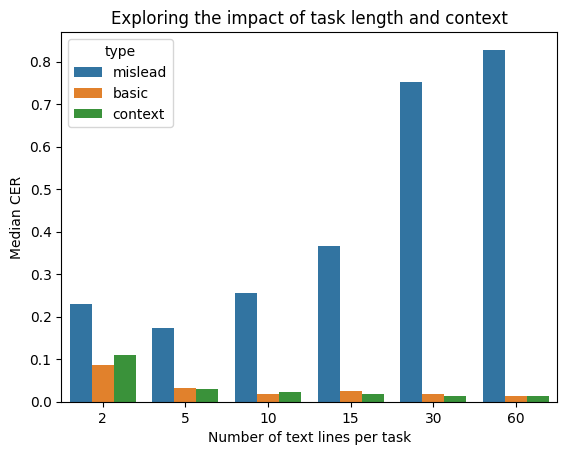

In [25]:
temp_plot = performance_vs_lines.loc[(performance_vs_lines['average']=='median')].copy()
temp_plot['type'] = temp_plot['type'].str.replace("spoof", 'untrue')
temp_plot['lines'] = temp_plot['lines'].astype(int)

temp_plot['type'] = np.where(temp_plot['type']=="untrue", "mislead", temp_plot['type'])
#temp_plot = temp_plot.loc[temp_plot['type']!='mislead']

sns.barplot(data =temp_plot, x = 'lines', y = 'CER', hue = 'type', hue_order = ['mislead', 'basic', 'context'])
plt.title('Exploring the impact of task length and context')
plt.xlabel('Number of text lines per task')
plt.ylabel('Median CER')
plt.savefig(os.path.join(save_figs,"performance_vs_lines.pdf"))
plt.show()

2024-05-11 22:13:15 matplotlib.category INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-11 22:13:15 matplotlib.category INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


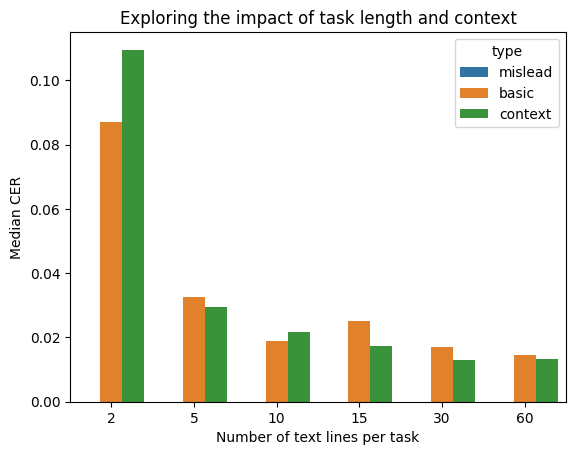

In [26]:
temp_plot = performance_vs_lines.loc[(performance_vs_lines['average']=='median')].copy()
temp_plot['type'] = temp_plot['type'].str.replace("spoof", 'untrue')
temp_plot['lines'] = temp_plot['lines'].astype(int)

temp_plot['type'] = np.where(temp_plot['type']=="untrue", "mislead", temp_plot['type'])
temp_plot = temp_plot.loc[temp_plot['type']!='mislead']

sns.barplot(data =temp_plot, x = 'lines', y = 'CER', hue = 'type', hue_order = ['mislead', 'basic', 'context'])
plt.title('Exploring the impact of task length and context')
plt.xlabel('Number of text lines per task')
plt.ylabel('Median CER')
#plt.savefig(os.path.join(save_figs,"performance_vs_lines.pdf"))
plt.show()